In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
from qiskit.circuit.library import RZZGate
import networkx as nx
from qiskit.providers.aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

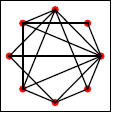

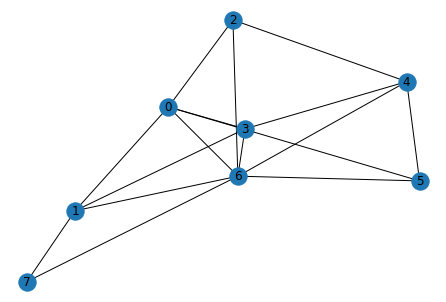

In [2]:
N = 8
graph=[(0, 1,1.0 ),(0, 2,2.0 ),(0, 3,5.0 ),(0, 5,1.0 ),(0, 6,3.0 ),(1, 3,2.0 ),(1, 6,1.0 ),(1, 7,4.0 ),
       (2, 4,1.0 ),(2, 6,1.0 ),(3, 4,2.0 ),(3, 6,3.0 ),(4, 5,1.0 ),(4, 6,1.0 ),(5, 6,2.0 ),(6, 7,1.0 )] 
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [3]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [4]:
def initialization(circuit):
    for qubit in circuit.qubits:
        circuit.h(qubit)
    return circuit

In [5]:
def cost_unitary_layer(circuit,gamma):
    for edge in graph:
        if edge[1] == edge[0] + 1:
            circuit.append(RZZGate(gamma*edge[2]),[edge[0],edge[0]+1])
        if edge[1] != edge[0] + 1:
            circuit.swap(edge[1],edge[0]+1)
            circuit.append(RZZGate(gamma*edge[2]),[edge[0],edge[0]+1])
            circuit.swap(edge[1],edge[0]+1)
    circuit.barrier()
    return circuit

In [6]:
def mixture_unitary_layer(circuit,alpha):
    for qubit in circuit.qubits:
        circuit.rx(alpha,qubit)
    circuit.barrier()
    return circuit

In [7]:
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

In [8]:
def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold

In [9]:
def anasatz(params):
    gammas, alphas = create_params(params)
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    circuit = QuantumCircuit(q,c)
    circuit = initialization(circuit)
    for i in range(n_layers):
        circuit = cost_unitary_layer(circuit, gammas[i])
        circuit = mixture_unitary_layer(circuit,alphas[i])
    #circuit.measure(circuit.qubits,c)
    
    
    simulator = StatevectorSimulator()
    result = execute(circuit,simulator).result()
    sv = result.get_statevector(circuit)
    states = Statevector(sv)
    counts = states.probabilities_dict(decimals=3)
    for key in counts.keys():
        counts[key] = int(1000*counts[key])
        
        
    results = counts.keys()
    new_res=[]
    for key in results:
        hold = array_of_key(key)
        for i in range(0,counts[key]):
            new_res.append(hold)
    return circuit,counts,new_res

In [10]:
def cost_function(params):
    circuit,counts,result = anasatz(params)
    total_cost = 0
    for i in range(len(result)):
        for edge in graph:
            total_cost += (A[edge[0]][edge[1]])*(1-2*result[i][edge[0]])*(1-2*result[i][edge[1]]) + (A[edge[1]][edge[0]])*(1-2*result[i][edge[1]])*(1-2*result[i][edge[0]])
    total_cost = total_cost/1024
    print("Cost: "+str(total_cost))
    return total_cost 

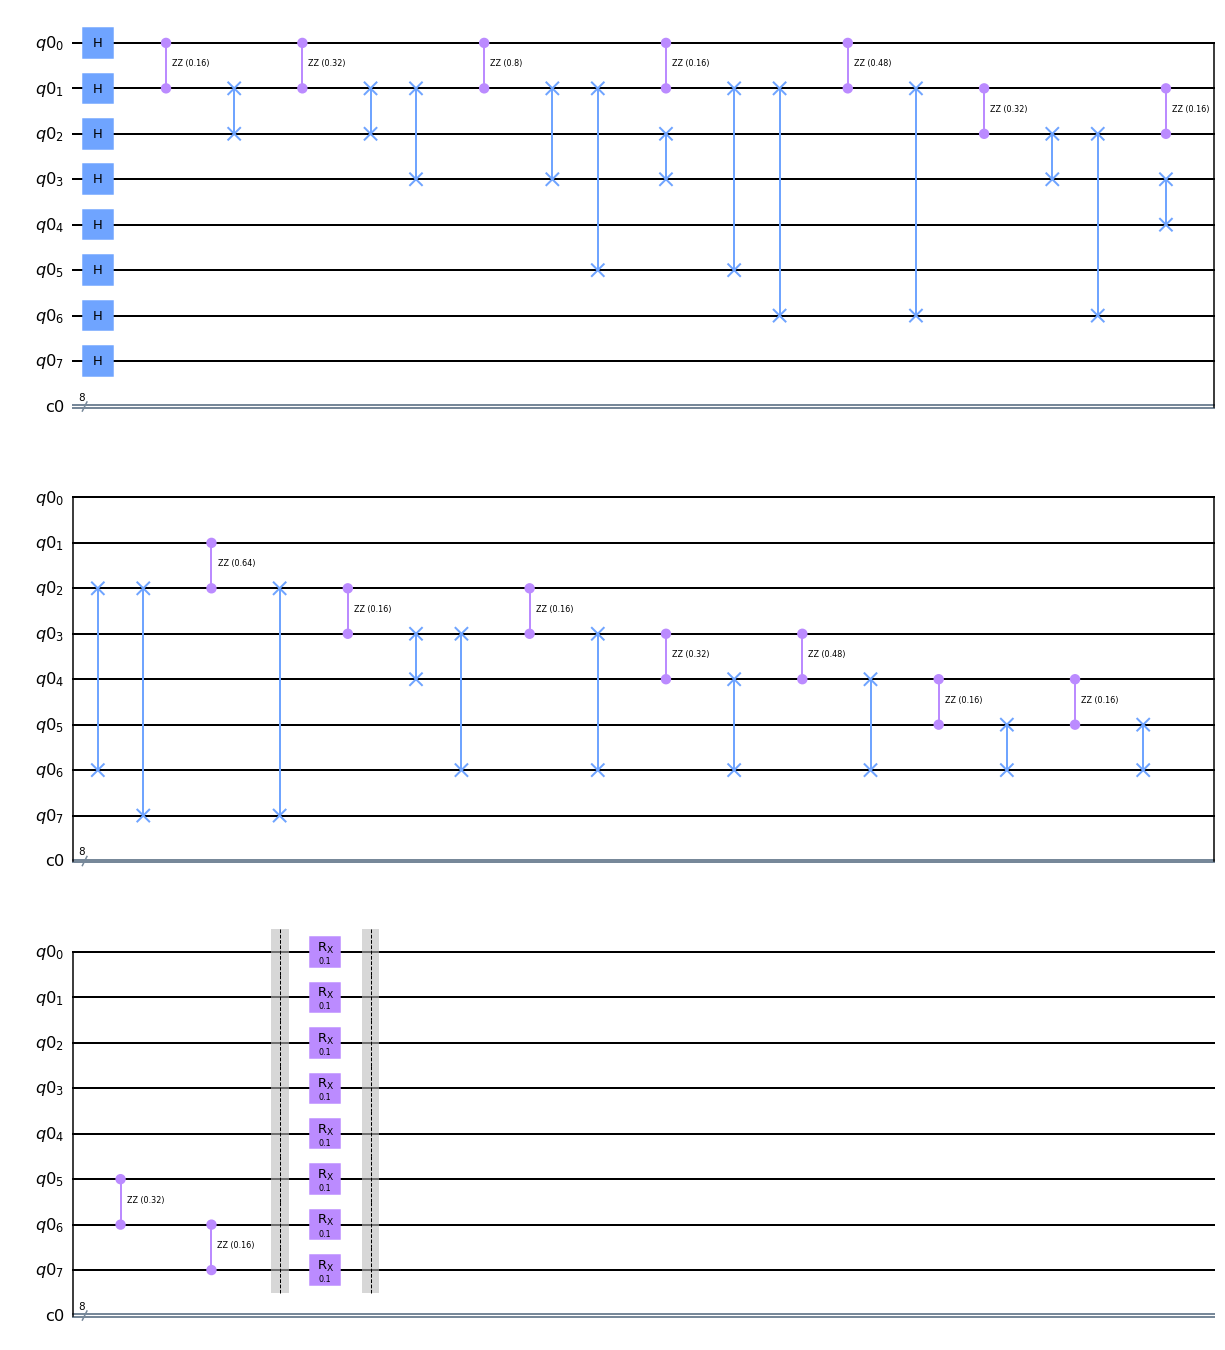

In [11]:
n_layers = 1
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
circuit,counts,result = anasatz(params)
circuit.draw('mpl')

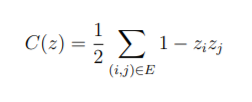

In [12]:
def get_approximation_ratio(z,b):
    c_z = 0
    c_z_max = 0
    z_a =array_of_key(z)
    for edge in graph:
        c_z = c_z + edge[2]*(1/2)*(1-((1-2*z_a[edge[0]])*(1-2*z_a[edge[1]])))
    for edge in graph:
        c_z_max = c_z_max + edge[2]*(1/2)*(1-((1-2*b[edge[0]])*(1-2*b[edge[1]])))
    app_ratio = c_z / c_z_max
    return app_ratio

In [13]:
def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    return z

In [14]:
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
b = xbest_brute


Best solution = [1, 1, 0, 0, 1, 0, 1, 0] cost = 25.0


optimization for depth :1
Cost: 0.0
Cost: 3.4765625
Cost: 0.0
Cost: 0.62109375
Cost: 4.453125
Cost: 4.33203125
Cost: 0.0
Cost: 2.3671875
Cost: -0.01171875
Cost: 1.65625
Cost: -0.125
Cost: -0.6953125
Cost: -0.12109375
Cost: -0.6953125
Cost: -0.80859375
Cost: -0.61328125
Cost: -0.78515625
Cost: -0.640625
Cost: -0.765625
Cost: -0.82421875
Cost: -0.76171875
Cost: -0.8359375
Cost: -0.81640625
Cost: -0.80859375
Cost: -0.8359375
Cost: -0.81640625
Cost: -0.8359375
Cost: -0.8359375
Cost: -0.8359375
Cost: -0.8359375
Out:      fun: -0.8359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([ 3.08631098, -1.97424985])
z with maximum frequency: 00101100
approxiamation ratio: 0.36


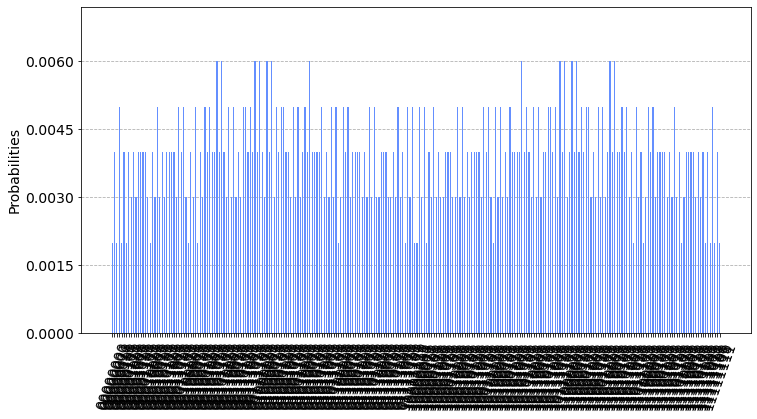

In [15]:
from qiskit.visualization import plot_histogram
collect_costs = []
collect_r = []
n_layers = 1
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 100
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (12,6),bar_labels = False)

optimization for depth :2
Cost: -0.01953125
Cost: 0.5234375
Cost: -0.46875
Cost: 4.109375
Cost: 0.23828125
Cost: 2.32421875
Cost: -0.27734375
Cost: 0.234375
Cost: 1.4765625
Cost: -0.6796875
Cost: -0.7734375
Cost: -1.69921875
Cost: 0.57421875
Cost: -1.50390625
Cost: -1.26171875
Cost: -1.48828125
Cost: -1.58203125
Cost: -1.796875
Cost: -1.8671875
Cost: -2.0546875
Cost: -1.91796875
Cost: -2.04296875
Cost: -1.140625
Cost: -1.8828125
Cost: -2.21875
Cost: -1.8671875
Cost: -2.1875
Cost: -2.2890625
Cost: -2.25
Cost: -2.52734375
Cost: -2.16796875
Cost: -2.25390625
Cost: -2.109375
Cost: -2.28515625
Cost: -2.390625
Cost: -2.46484375
Cost: -2.453125
Cost: -2.3984375
Cost: -2.4921875
Cost: -2.46484375
Cost: -2.4921875
Cost: -2.52734375
Cost: -2.51171875
Cost: -2.5234375
Cost: -2.5234375
Cost: -2.4921875
Cost: -2.52734375
Cost: -2.5
Cost: -2.52734375
Cost: -2.52734375
Cost: -2.52734375
Out:      fun: -2.52734375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 51
  status: 1

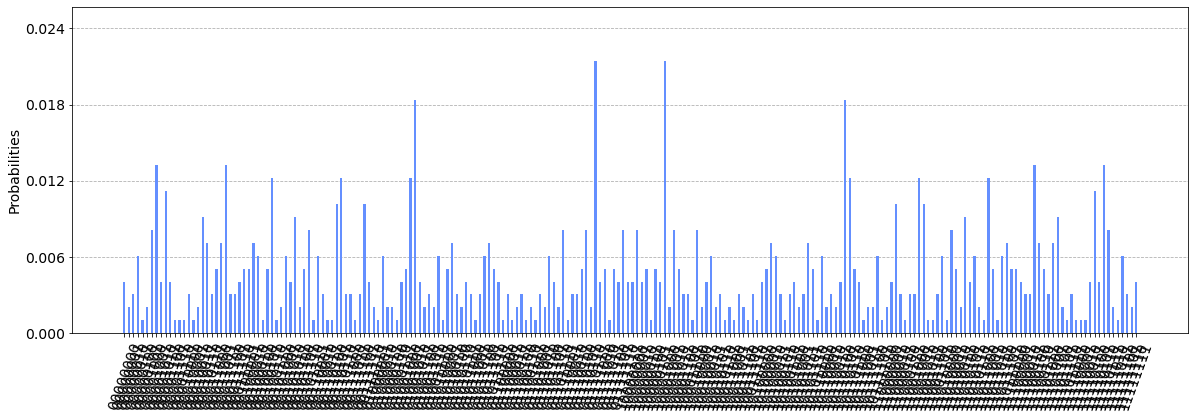

In [16]:
n_layers = 2
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 100
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (20,6),bar_labels = False)

optimization for depth :3
Cost: 0.50390625
Cost: -1.91796875
Cost: -3.32421875
Cost: -0.8984375
Cost: -0.6171875
Cost: 1.6171875
Cost: 9.6796875
Cost: 3.09765625
Cost: 0.6875
Cost: -1.30078125
Cost: 1.015625
Cost: -3.08984375
Cost: -0.4921875
Cost: 0.03125
Cost: -1.6875
Cost: -3.51953125
Cost: -4.11328125
Cost: -4.046875
Cost: -4.10546875
Cost: -3.1328125
Cost: -4.23828125
Cost: -3.44140625
Cost: -4.44140625
Cost: -3.84375
Cost: -3.4296875
Cost: -3.796875
Cost: -4.0390625
Cost: -4.5703125
Cost: -4.53125
Cost: -4.37109375
Cost: -4.4453125
Cost: -4.25
Cost: -4.58203125
Cost: -4.34765625
Cost: -4.4296875
Cost: -4.18359375
Cost: -4.4765625
Cost: -4.40625
Cost: -4.46484375
Cost: -4.55859375
Cost: -4.32421875
Cost: -4.5703125
Cost: -4.4609375
Cost: -4.5703125
Cost: -4.59765625
Cost: -4.59765625
Cost: -4.609375
Cost: -4.6484375
Cost: -4.62890625
Cost: -4.6484375
Cost: -4.66015625
Cost: -4.66015625
Cost: -4.6015625
Cost: -4.65625
Cost: -4.61328125
Cost: -4.66015625
Cost: -4.66015625
Cost: -4.6

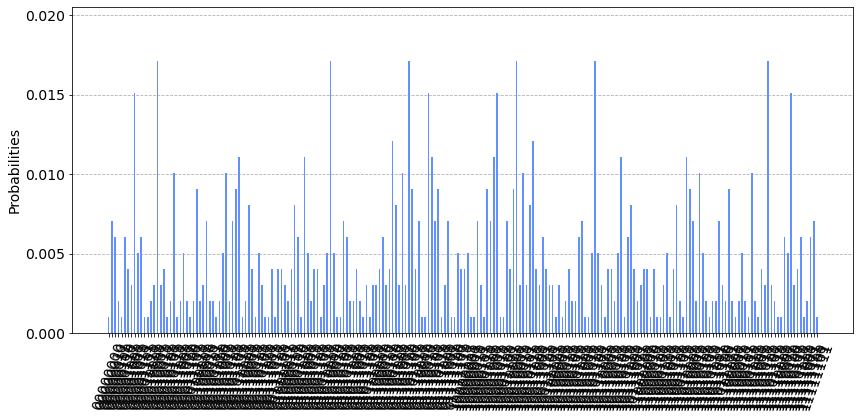

In [17]:
n_layers = 3
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 100
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)


print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (14,6),bar_labels = False)

optimization for depth :4
Cost: 1.47265625
Cost: 1.09765625
Cost: -3.60546875
Cost: 1.55078125
Cost: -2.3984375
Cost: -3.5625
Cost: -1.3125
Cost: -3.6484375
Cost: -1.6015625
Cost: -0.09765625
Cost: -6.6484375
Cost: -1.62890625
Cost: -6.21484375
Cost: -0.36328125
Cost: -6.296875
Cost: -3.7734375
Cost: -3.84375
Cost: -5.89453125
Cost: -7.765625
Cost: 6.84765625
Cost: -7.046875
Cost: -3.703125
Cost: -4.81640625
Cost: -6.984375
Cost: -5.38671875
Cost: -6.42578125
Cost: -7.77734375
Cost: -6.4140625
Cost: -7.3203125
Cost: -7.09375
Cost: -7.625
Cost: -7.81640625
Cost: -6.89453125
Cost: -7.7265625
Cost: -8.3046875
Cost: -8.6953125
Cost: -9.26953125
Cost: -8.86328125
Cost: -9.0859375
Cost: -8.65625
Cost: -8.9609375
Cost: -9.2734375
Cost: -9.39453125
Cost: -8.7265625
Cost: -9.296875
Cost: -8.984375
Cost: -9.421875
Cost: -9.41796875
Cost: -9.453125
Cost: -8.875
Cost: -9.55078125
Cost: -9.49609375
Cost: -9.4296875
Cost: -9.546875
Cost: -9.2734375
Cost: -9.5
Cost: -9.29296875
Cost: -9.54296875
Cost

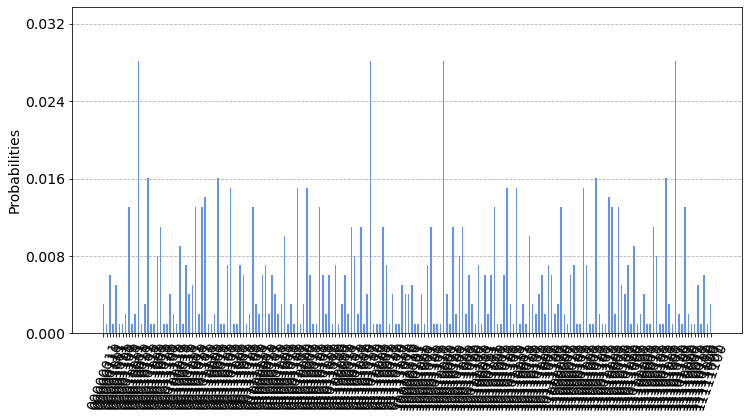

In [18]:
n_layers = 4
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 100
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (12,6),bar_labels = False)

optimization for depth :5
Cost: -0.4453125
Cost: 0.73828125
Cost: 3.44921875
Cost: 0.546875
Cost: -1.26953125
Cost: 0.96484375
Cost: 1.0390625
Cost: 1.4765625
Cost: -2.234375
Cost: -0.0859375
Cost: 0.41796875
Cost: -4.4375
Cost: 0.83984375
Cost: -2.625
Cost: 1.74609375
Cost: 2.5390625
Cost: -3.40234375
Cost: -4.01953125
Cost: 2.24609375
Cost: -4.0234375
Cost: -6.30078125
Cost: -5.6953125
Cost: 6.26953125
Cost: -5.55078125
Cost: -5.12109375
Cost: -3.796875
Cost: -3.0546875
Cost: -6.27734375
Cost: -6.96484375
Cost: -6.78515625
Cost: -6.328125
Cost: -5.39453125
Cost: -5.70703125
Cost: -7.12109375
Cost: -7.10546875
Cost: -5.77734375
Cost: -7.26953125
Cost: -7.3984375
Cost: -6.140625
Cost: -7.1015625
Cost: -5.84375
Cost: -6.78125
Cost: -6.22265625
Cost: -7.1640625
Cost: -7.57421875
Cost: -6.75390625
Cost: -7.65234375
Cost: -7.41796875
Cost: -7.63671875
Cost: -7.42578125
Cost: -7.7421875
Cost: -7.1796875
Cost: -7.5625
Cost: -7.69921875
Cost: -8.0
Cost: -7.87109375
Cost: -7.91015625
Cost: -8.

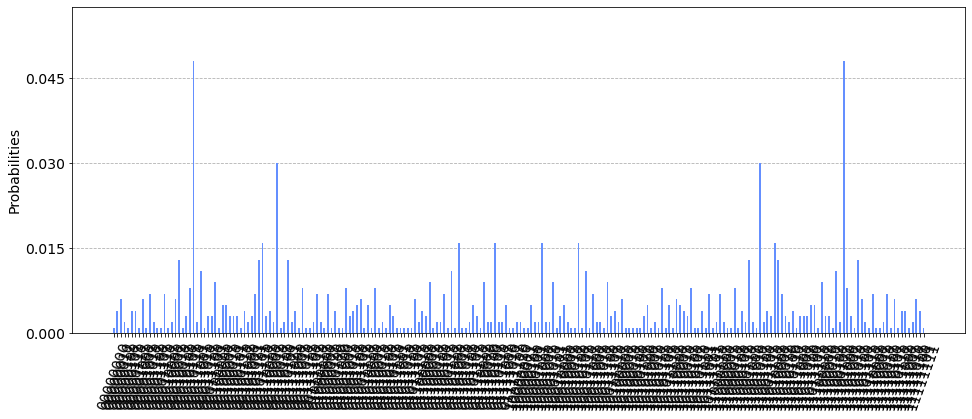

In [19]:
n_layers = 5
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 150
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (16,6),bar_labels = False)

optimization for depth :6
Cost: 0.7109375
Cost: 2.5859375
Cost: 0.9921875
Cost: -1.1640625
Cost: 0.22265625
Cost: 2.7265625
Cost: 2.54296875
Cost: 3.7890625
Cost: -0.3359375
Cost: 4.78125
Cost: -0.765625
Cost: -0.8671875
Cost: -3.0703125
Cost: 0.14453125
Cost: -1.1796875
Cost: -3.54296875
Cost: -0.37109375
Cost: -0.1953125
Cost: -0.4375
Cost: -2.3671875
Cost: -2.79296875
Cost: -3.05078125
Cost: -0.53515625
Cost: -3.75
Cost: 0.71484375
Cost: -1.65234375
Cost: -3.2109375
Cost: -2.2421875
Cost: -0.0546875
Cost: -1.39453125
Cost: -2.8125
Cost: -1.90625
Cost: -1.0390625
Cost: -3.83984375
Cost: -3.9375
Cost: -2.98046875
Cost: -4.23828125
Cost: -3.69140625
Cost: -4.18359375
Cost: -3.21875
Cost: -3.71875
Cost: -2.9765625
Cost: -4.07421875
Cost: -3.61328125
Cost: -4.53125
Cost: -4.421875
Cost: -4.5078125
Cost: -4.56640625
Cost: -4.54296875
Cost: -4.578125
Cost: -4.62890625
Cost: -4.46484375
Cost: -4.4375
Cost: -3.83203125
Cost: -4.52734375
Cost: -4.66796875
Cost: -4.62890625
Cost: -4.328125
Cos

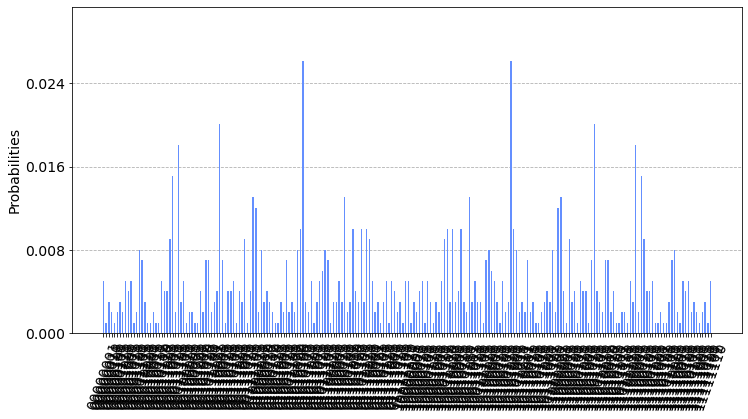

In [20]:
n_layers = 6
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 150
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (12,6),bar_labels = False)

optimization for depth :7
Cost: 1.4765625
Cost: 1.734375
Cost: 1.4921875
Cost: 1.31640625
Cost: -1.61328125
Cost: -0.78515625
Cost: -2.49609375
Cost: 1.52734375
Cost: -1.4921875
Cost: -0.5703125
Cost: -1.69921875
Cost: -0.96875
Cost: -2.6640625
Cost: -1.30859375
Cost: -0.80078125
Cost: 0.984375
Cost: -0.32421875
Cost: 3.27734375
Cost: -1.66015625
Cost: -0.0546875
Cost: -0.734375
Cost: -1.09765625
Cost: -3.0546875
Cost: -2.30078125
Cost: -1.36328125
Cost: -3.29296875
Cost: -4.91015625
Cost: -3.265625
Cost: -3.3515625
Cost: -4.109375
Cost: 0.05078125
Cost: -4.95703125
Cost: 1.25
Cost: -3.33984375
Cost: -0.0078125
Cost: -2.875
Cost: -5.2265625
Cost: -3.79296875
Cost: -5.43359375
Cost: -1.25
Cost: -5.12109375
Cost: -1.92578125
Cost: -5.03515625
Cost: -2.99609375
Cost: -6.1796875
Cost: -4.01953125
Cost: -6.4921875
Cost: -4.0234375
Cost: -6.65625
Cost: -6.78515625
Cost: -5.57421875
Cost: -7.48046875
Cost: -5.53125
Cost: -6.89453125
Cost: -5.34375
Cost: -7.4453125
Cost: -7.48828125
Cost: -7.2

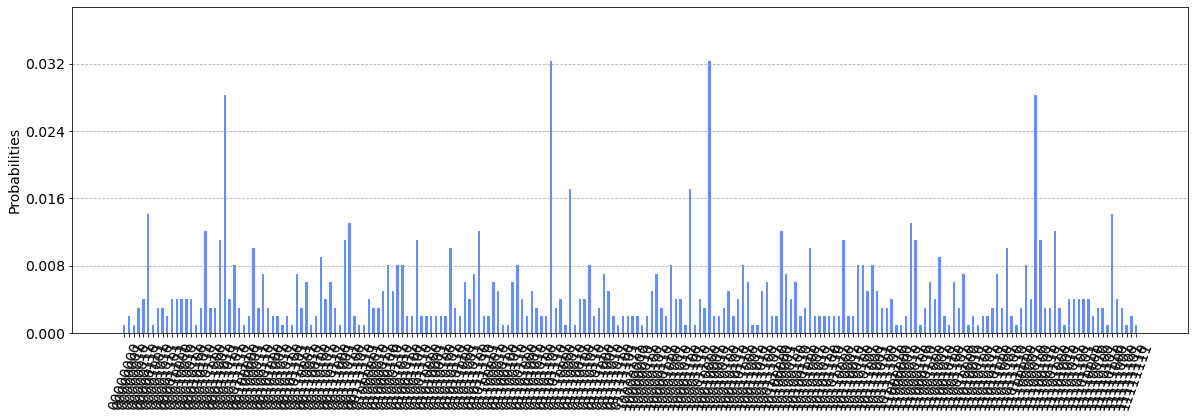

In [21]:
n_layers = 7
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 180
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (20,6),bar_labels = False)

optimization for depth :8
Cost: 0.671875
Cost: 0.43359375
Cost: 1.0
Cost: -0.79296875
Cost: -0.7890625
Cost: -0.9453125
Cost: 0.05078125
Cost: -0.9140625
Cost: 0.8203125
Cost: 2.01953125
Cost: 0.92578125
Cost: 1.0703125
Cost: -1.0
Cost: 0.34375
Cost: -1.6640625
Cost: -1.640625
Cost: 0.01171875
Cost: 3.72265625
Cost: -0.87890625
Cost: 0.0625
Cost: -1.8359375
Cost: 0.671875
Cost: -1.10546875
Cost: 0.09765625
Cost: -0.4453125
Cost: -0.59375
Cost: 0.0546875
Cost: 0.94921875
Cost: -1.34375
Cost: 0.37109375
Cost: 0.15625
Cost: -1.79296875
Cost: -1.484375
Cost: -2.40625
Cost: 0.40234375
Cost: -3.46875
Cost: 0.4609375
Cost: -1.9375
Cost: 0.65625
Cost: -1.6484375
Cost: -0.54296875
Cost: -2.0390625
Cost: -1.71484375
Cost: 0.15234375
Cost: -2.734375
Cost: -2.32421875
Cost: -3.5546875
Cost: 0.3515625
Cost: -4.5
Cost: -3.51953125
Cost: -3.8515625
Cost: -4.01171875
Cost: -3.21875
Cost: -4.5390625
Cost: -4.0859375
Cost: -3.86328125
Cost: -4.609375
Cost: -4.265625
Cost: -3.14453125
Cost: -4.4921875
Co

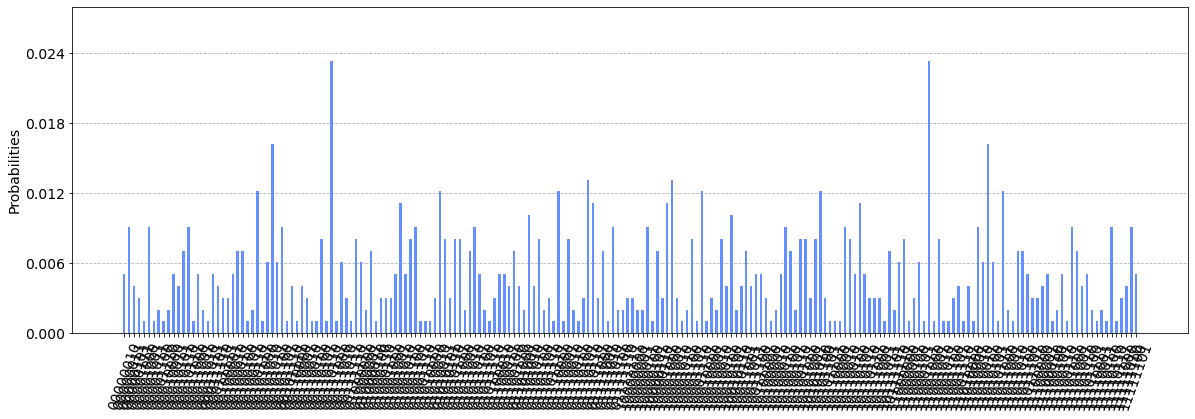

In [22]:
n_layers = 8
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*n_layers)]
num_iters = 200
print("optimization for depth :{}".format(n_layers))
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})
print(f'Out: {out}')
collect_costs.append(out.fun)
circuit,counts,result = anasatz(out['x'])

z = get_maximum_z(counts)
print("z with maximum frequency: "+str(z))
r = get_approximation_ratio(z,b)
collect_r.append(r)
print("approxiamation ratio: "+str(r))
plot_histogram(counts,figsize = (20,6),bar_labels = False)

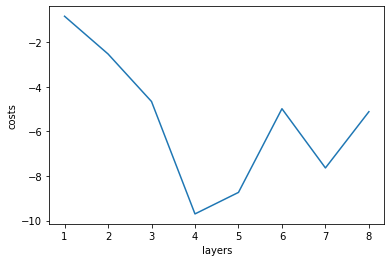

In [23]:
x = [1,2,3,4,5,6,7,8]
y = collect_costs
plt.plot(x,y)
plt.xlabel("layers")
plt.ylabel("costs")
plt.show()

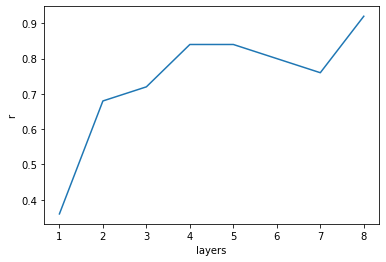

In [24]:
x = [1,2,3,4,5,6,7,8]
y = collect_r
plt.plot(x,y)
plt.xlabel("layers")
plt.ylabel("r")
plt.show()